#**Multi Event Study**

##Data collection and preprocessing

###Fetch articles for each event

In [ ]:
import requests
import pandas as pd
from io import StringIO


GDELT_DOCS_URL = "https://api.gdeltproject.org/api/v2/doc/doc"


queries = [
    "RBI MPC India",
    "repo rate India",
    "monetary policy committee India",
    "MPC Meeting India",
    "repo rate RBI"
]


# Define all time periods
date_ranges = [
    ("2025-01-28", "2025-02-15"),
    ("2025-05-27", "2025-06-15"),
    ("2025-07-28", "2025-08-15"),
    ("2025-11-25", "2025-12-15")
]


all_rows = []
printed_cols = False  # only print columns once


# Loop through each time period
for BASE_START_DATE, BASE_END_DATE in date_ranges:
    print(f"\n📅 Fetching data for period: {BASE_START_DATE} to {BASE_END_DATE}")

    for query in queries:
        # Convert YYYY-MM-DD to YYYYMMDDHHMMSS format for GDELT
        gdelt_start_dt = pd.to_datetime(BASE_START_DATE).strftime("%Y%m%d%H%M%S")
        gdelt_end_dt = pd.to_datetime(BASE_END_DATE).strftime("%Y%m%d%H%M%S")


        params = {
            "query": query,
            "mode": "ArtList",
            "format": "CSV",
            "maxrecords": 250,
            "startdatetime": gdelt_start_dt,
            "enddatetime": gdelt_end_dt
        }


        r = requests.get(GDELT_DOCS_URL, params=params)
        if r.status_code != 200:
            print(f"Query '{query}' failed with status {r.status_code}, text: {r.text[:200]}")
            continue


        csv_text = r.text.strip()
        # Check for GDELT specific error message in csv_text
        if not csv_text or "Invalid query start date format" in csv_text or "No results" in csv_text:
            print(f"Query '{query}' returned empty or invalid CSV: {csv_text}")
            continue


        try:
            df = pd.read_csv(StringIO(csv_text))
        except Exception as e:
            print(f"Error reading CSV for query '{query}': {e}. Raw text: {csv_text[:200]}")
            continue


        if df.empty:
            print(f"DataFrame for query '{query}' is empty after reading CSV.")
            continue


        # Convert column names to lowercase for consistent access
        df.columns = df.columns.str.lower()


        if not printed_cols:
            print("Columns from GDELT (after lowercase conversion):", list(df.columns))
            printed_cols = True


        # --- choose timestamp column ---
        timestamp_col_candidates = ["seendate", "date", "sqldate", "publishdate"]
        ts_col = None
        for c in timestamp_col_candidates:
            if c in df.columns:
                ts_col = c
                break


        if ts_col is None:
            print(f"No known timestamp column found for query '{query}'; adding placeholder timestamps.")
            df["timestamp"] = pd.NaT
            df["date"] = pd.NaT
        else:
            df["timestamp"] = pd.to_datetime(df[ts_col], errors="coerce")
            df["date"] = df["timestamp"].dt.date


        # --- choose URL and title/source columns ---
        url_col_candidates = ["url", "sourceurl"]
        title_col_candidates = ["title", "documentidentifier", "headline"]
        domain_col_candidates = ["domain", "sourcecommonname", "source"]


        url_col = next((c for c in url_col_candidates if c in df.columns), None)
        title_col = next((c for c in title_col_candidates if c in df.columns), None)
        domain_col = next((c for c in domain_col_candidates if c in df.columns), None)


        # Build text field robustly
        if title_col and not df[title_col].empty:
            title_series = df[title_col].astype(str).fillna("")
        else:
            title_series = pd.Series([""] * len(df), index=df.index)


        if url_col and not df[url_col].empty:
            url_series = df[url_col].astype(str).fillna("")
        else:
            url_series = pd.Series([""] * len(df), index=df.index)


        df["text"] = title_series + ". " + url_series


        # Source/domain
        if domain_col and not df[domain_col].empty:
            df["source"] = df[domain_col]
        else:
            df["source"] = "GDELT"


        keep_cols = ["text", "date", "timestamp", "source"]
        if url_col:
            keep_cols.append(url_col)


        # Filter df to keep only existing columns among keep_cols before appending
        df_to_append = df[[col for col in keep_cols if col in df.columns]]
        all_rows.append(df_to_append)


if all_rows:
    NewsDF5 = pd.concat(all_rows, ignore_index=True)
else:
    NewsDF5 = pd.DataFrame(columns=["text", "date", "timestamp", "source"])


print(f"\n✅ Total {len(NewsDF5)} GDELT article entries across all time periods")
print(NewsDF5.head())



📅 Fetching data for period: 2025-01-28 to 2025-02-15
Columns from GDELT (after lowercase conversion): ['url', 'mobileurl', 'date', 'title']

📅 Fetching data for period: 2025-05-27 to 2025-06-15

📅 Fetching data for period: 2025-07-28 to 2025-08-15

📅 Fetching data for period: 2025-11-25 to 2025-12-15

✅ Total 4746 GDELT article entries across all time periods
                                                text        date  \
0  RBI Monetary Policy Meeting 2025 Expectations ...  2025-02-06   
1  RBI Monetary Policy Meeting Highlights : Repo ...  2025-02-07   
2  RBI MPC Meeting 2025 : When & How To Watch San...  2025-02-07   
3  All Eyes On RBI As MPC Meeting Begins Tomorrow...  2025-02-04   
4  India wholesale inflation eases at 2 . 31 % in...  2025-02-14   

            timestamp source  \
0 2025-02-06 05:30:00  GDELT   
1 2025-02-07 05:00:00  GDELT   
2 2025-02-07 04:00:00  GDELT   
3 2025-02-04 06:15:00  GDELT   
4 2025-02-14 07:00:00  GDELT   

                                   

In [ ]:
NewsDF5.info()


NameError: name 'NewsDF5' is not defined

In [ ]:
NewsDF5['url'].nunique()

2117

In [ ]:
Newsdf = NewsDF5.drop_duplicates(subset=['url'])
print(f"Number of rows after dropping duplicate URLs: {len(Newsdf)}")

Number of rows after dropping duplicate URLs: 2117


In [ ]:
Newsdf.to_csv('Newsdf.csv', index=False)

NameError: name 'Newsdf' is not defined

###Fetch Nifty data for the relavant time frames (around MPC announcements of Feb, Jun, Aug and Dec 2025).

In [ ]:
import yfinance as yf
import pandas as pd

# Define all time periods
date_ranges = [
    ("2025-01-28", "2025-02-15"),
    ("2025-05-27", "2025-06-15"),
    ("2025-07-28", "2025-08-15"),
    ("2025-11-25", "2025-12-15")
]

all_nifty_data = []

# Loop through each time period
for start_date, end_date in date_ranges:
    print(f"📅 Downloading Nifty data for: {start_date} to {end_date}")

    nifty_period = yf.download("^NSEI", start=start_date, end=end_date, interval="1h", progress=False)

    if not nifty_period.empty:
        nifty_period['returns_1h'] = nifty_period['Close'].pct_change()  # Changed: 1 period for 1h data
        all_nifty_data.append(nifty_period)
    else:
        print(f"⚠️ No data retrieved for {start_date} to {end_date}")

# Combine all periods into a single DataFrame
if all_nifty_data:
    nifty = pd.concat(all_nifty_data)
    nifty.to_csv('nifty.csv')
    print(f"✅ Nifty 1h data saved: {len(nifty)} records across all four periods")
    print(f"Date range: {nifty.index.min()} to {nifty.index.max()}")
else:
    print("❌ No data retrieved for any period")


📅 Downloading Nifty data for: 2025-01-28 to 2025-02-15


/tmp/ipython-input-3391145555.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nifty_period = yf.download("^NSEI", start=start_date, end=end_date, interval="1h", progress=False)


📅 Downloading Nifty data for: 2025-05-27 to 2025-06-15
📅 Downloading Nifty data for: 2025-07-28 to 2025-08-15


/tmp/ipython-input-3391145555.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nifty_period = yf.download("^NSEI", start=start_date, end=end_date, interval="1h", progress=False)
/tmp/ipython-input-3391145555.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nifty_period = yf.download("^NSEI", start=start_date, end=end_date, interval="1h", progress=False)


📅 Downloading Nifty data for: 2025-11-25 to 2025-12-15
✅ Nifty 1h data saved: 399 records across all four periods
Date range: 2025-01-28 03:45:00+00:00 to 2025-12-12 09:45:00+00:00


/tmp/ipython-input-3391145555.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nifty_period = yf.download("^NSEI", start=start_date, end=end_date, interval="1h", progress=False)


In [ ]:
nifty=pd.read_csv('nifty.csv')

In [ ]:
nifty.columns

MultiIndex([(     'Close', '^NSEI'),
            (      'High', '^NSEI'),
            (       'Low', '^NSEI'),
            (      'Open', '^NSEI'),
            (    'Volume', '^NSEI'),
            ('returns_1h',      '')],
           names=['Price', 'Ticker'])

In [ ]:
nifty.head()

Price,Close,High,Low,Open,Volume,returns_1h
Ticker,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI,
Datetime,,,,,,
2025-01-28 03:45:00+00:00,22881.250000,22969.150391,22860.300781,22967.949219,0,NaN
2025-01-28 04:45:00+00:00,22959.599609,22985.949219,22858.650391,22882.500000,0,0.003424
2025-01-28 05:45:00+00:00,23032.650391,23040.650391,22944.300781,22958.550781,0,0.003182
2025-01-28 06:45:00+00:00,23065.250000,23068.550781,22999.099609,23032.150391,0,0.001415
2025-01-28 07:45:00+00:00,23051.750000,23075.550781,23021.750000,23067.349609,0,-0.000585


###Fix Datetime format from UTC to IST and make hours_from_mpc column

The data is given in UTC datetime format. Change to IST




In [ ]:
import pandas as pd
import numpy as np

# MPC announcement times in IST
mpc_times = {
    '2025-02-06': '2025-02-06 10:00:00',
    '2025-06-06': '2025-06-06 10:00:00',
    '2025-08-06': '2025-08-06 10:00:00',
    '2025-12-05': '2025-12-05 10:00:00',
}

mpc_times = {pd.to_datetime(k): pd.to_datetime(v) for k, v in mpc_times.items()}


Now we will fix the time format from UTC to IST for both news and nifty datasets. We shall also create a new column called hours_from_mpc. Why i have made this column, will become clear later on.

In [ ]:
import pandas as pd
import numpy as np
import re

#For News Articles dataset first

all_articles = pd.read_csv('/content/Newsdf.csv')

policy_keywords = (
    r"rate|rates|repo|reverse repo|benchmark|"
    r"hike|hikes|hiked|cut|cuts|cutting|"
    r"policy|monetary policy|stance|guidance|"
    r"inflation|cpi|wpi|price pressure|"
    r"growth|gdp|output|economic activity|slowdown|recovery|"
    r"liquidity|accommodative|easing|tight|tightening|"
    r"neutral stance|pause|no change|"
    r"credit|lending|borrowing|emi|loan rates|deposit rates|"
    r"bond yields|yields|gilts|sovereign bonds|"
    r"hawkish|more hawkish|less hawkish|"
    r"dovish|more dovish|less dovish|"
    r"RBI|Reserve Bank of India|central bank|"
    r"MPC|monetary policy committee"
)

news = all_articles[
    all_articles['text'].str.contains(policy_keywords, case=False, na=False, regex=True)
].copy()

# Parse timestamp (GDELT provides UTC timestamps)
news['timestamp'] = pd.to_datetime(news['timestamp'])

# Convert from UTC to IST
if news['timestamp'].dt.tz is None:
    news['timestamp'] = news['timestamp'].dt.tz_localize('UTC')

news['timestamp_IST'] = news['timestamp'].dt.tz_convert('Asia/Kolkata')

# Extract date only from IST timestamp
news['date_only'] = news['timestamp_IST'].dt.date
news['date_only'] = pd.to_datetime(news['date_only'])

# Define MPC times in IST (10:00 AM)
mpc_times = {
    pd.to_datetime('2025-02-06'): pd.to_datetime('2025-02-06 10:00:00'),
    pd.to_datetime('2025-06-06'): pd.to_datetime('2025-06-06 10:00:00'),
    pd.to_datetime('2025-08-06'): pd.to_datetime('2025-08-06 10:00:00'),
    pd.to_datetime('2025-12-05'): pd.to_datetime('2025-12-05 10:00:00')
}

# Function to get the correct MPC time for each row
def get_mpc_time(row_date):
    if row_date in mpc_times:
        return mpc_times[row_date]
    if pd.to_datetime('2025-01-28') <= row_date <= pd.to_datetime('2025-02-15'):
        return mpc_times[pd.to_datetime('2025-02-06')]
    if pd.to_datetime('2025-05-27') <= row_date <= pd.to_datetime('2025-06-15'):
        return mpc_times[pd.to_datetime('2025-06-06')]
    if pd.to_datetime('2025-07-28') <= row_date <= pd.to_datetime('2025-08-15'):
        return mpc_times[pd.to_datetime('2025-08-06')]
    if pd.to_datetime('2025-11-25') <= row_date <= pd.to_datetime('2025-12-15'):
        return mpc_times[pd.to_datetime('2025-12-05')]
    return np.nan

news['mpc_time'] = news['date_only'].apply(get_mpc_time)

# Compute hours_from_mpc using IST timestamp
news['hours_from_mpc'] = (news['timestamp_IST'].dt.tz_localize(None) - news['mpc_time']) / pd.Timedelta(hours=1)

# Filter to rows that belong to any MPC window
news = news[~news['mpc_time'].isna()].copy()

news.to_csv('Newsdf_with_hours_from_mpc.csv', index=False)
print(f"✅ Saved {len(news)} news articles with hours_from_mpc calculated in IST")



✅ Saved 1758 news articles with hours_from_mpc calculated in IST


In [ ]:
#For NIFTY dataset now

nifty_raw = pd.read_csv('nifty.csv', header=[0,1])

# Flatten multi-level columns
nifty = nifty_raw.copy()
nifty.columns = nifty.columns.get_level_values(0)

# First column is datetime
nifty = nifty.rename(columns={nifty.columns[0]: 'Datetime'})

# Drop header rows
nifty = nifty[nifty['Datetime'] != 'Datetime'].copy()
nifty = nifty.dropna(subset=['Datetime']).copy()

# Parse datetime (yfinance provides UTC timestamps)
nifty['Datetime'] = pd.to_datetime(nifty['Datetime'], errors='coerce')
nifty = nifty.dropna(subset=['Datetime']).copy()

# Convert numeric columns
for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    if col in nifty.columns:
        nifty[col] = pd.to_numeric(nifty[col], errors='coerce')

# Calculate returns
nifty['returns_1h'] = nifty['Close'].pct_change()

# Convert from UTC to IST
if nifty['Datetime'].dt.tz is None:
    nifty['Datetime'] = nifty['Datetime'].dt.tz_localize('UTC')

nifty['Datetime_IST'] = nifty['Datetime'].dt.tz_convert('Asia/Kolkata')

# Extract date only from IST timestamp
nifty['date_only'] = nifty['Datetime_IST'].dt.date
nifty['date_only'] = pd.to_datetime(nifty['date_only'])

# Apply MPC time function
nifty['mpc_time'] = nifty['date_only'].apply(get_mpc_time)

# Compute hours_from_mpc using IST timestamp
nifty['hours_from_mpc'] = (nifty['Datetime_IST'].dt.tz_localize(None) - nifty['mpc_time']) / pd.Timedelta(hours=1)

# Filter to rows that belong to any MPC window
nifty = nifty[~nifty['mpc_time'].isna()].copy()

nifty.to_csv('nifty_with_hours_from_mpc.csv', index=False)
print(f"✅ Saved {len(nifty)} Nifty records with hours_from_mpc calculated in IST")


✅ Saved 399 Nifty records with hours_from_mpc calculated in IST


In [ ]:
news.head()

,text,date,timestamp,source,url,timestamp_IST,date_only,mpc_time,hours_from_mpc
0,RBI Monetary Policy Meeting 2025 Expectations ...,2025-02-06,2025-02-06 05:30:00+00:00,GDELT,https://www.thehindubusinessline.com/money-and...,2025-02-06 11:00:00+05:30,2025-02-06,2025-02-06 10:00:00,1.00
1,RBI Monetary Policy Meeting Highlights : Repo ...,2025-02-07,2025-02-07 05:00:00+00:00,GDELT,https://economictimes.indiatimes.com/news/econ...,2025-02-07 10:30:00+05:30,2025-02-07,2025-02-06 10:00:00,24.50
2,RBI MPC Meeting 2025 : When & How To Watch San...,2025-02-07,2025-02-07 04:00:00+00:00,GDELT,https://www.news18.com/business/economy/rbi-mp...,2025-02-07 09:30:00+05:30,2025-02-07,2025-02-06 10:00:00,23.50
3,All Eyes On RBI As MPC Meeting Begins Tomorrow...,2025-02-04,2025-02-04 06:15:00+00:00,GDELT,https://www.freepressjournal.in/business/all-e...,2025-02-04 11:45:00+05:30,2025-02-04,2025-02-06 10:00:00,-46.25
4,India wholesale inflation eases at 2 . 31 % in...,2025-02-14,2025-02-14 07:00:00+00:00,GDELT,https://economictimes.indiatimes.com/news/econ...,2025-02-14 12:30:00+05:30,2025-02-14,2025-02-06 10:00:00,194.50


In [ ]:
nifty.head()

,Datetime,Close,High,Low,Open,Volume,returns_1h,Datetime_IST,date_only,mpc_time,hours_from_mpc
1,2025-01-28 03:45:00+00:00,22881.250000,22969.150391,22860.300781,22967.949219,0.0,NaN,2025-01-28 09:15:00+05:30,2025-01-28,2025-02-06 10:00:00,-216.75
2,2025-01-28 04:45:00+00:00,22959.599609,22985.949219,22858.650391,22882.500000,0.0,0.003424,2025-01-28 10:15:00+05:30,2025-01-28,2025-02-06 10:00:00,-215.75
3,2025-01-28 05:45:00+00:00,23032.650391,23040.650391,22944.300781,22958.550781,0.0,0.003182,2025-01-28 11:15:00+05:30,2025-01-28,2025-02-06 10:00:00,-214.75
4,2025-01-28 06:45:00+00:00,23065.250000,23068.550781,22999.099609,23032.150391,0.0,0.001415,2025-01-28 12:15:00+05:30,2025-01-28,2025-02-06 10:00:00,-213.75
5,2025-01-28 07:45:00+00:00,23051.750000,23075.550781,23021.750000,23067.349609,0.0,-0.000585,2025-01-28 13:15:00+05:30,2025-01-28,2025-02-06 10:00:00,-212.75


##Sentiment Classification task

###Make a labelled dataset on which i can train my sentiment classifier.

First, I will sample some articles from August and export them so that i may manually label the sample. Later I will upload back the labelled dataset.

In [ ]:
news.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1758 entries, 0 to 2116
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype                       
---  ------          --------------  -----                       
 0   text            1758 non-null   object                      
 1   date            1758 non-null   object                      
 2   timestamp       1758 non-null   datetime64[ns, UTC]         
 3   source          1758 non-null   object                      
 4   url             1758 non-null   object                      
 5   timestamp_IST   1758 non-null   datetime64[ns, Asia/Kolkata]
 6   date_only       1758 non-null   datetime64[ns]              
 7   mpc_time        1758 non-null   datetime64[ns]              
 8   hours_from_mpc  1758 non-null   float64                     
dtypes: datetime64[ns, Asia/Kolkata](1), datetime64[ns, UTC](1), datetime64[ns](2), float64(1), object(4)
memory usage: 201.9+ KB


In [ ]:
news_aligned = news[['text', 'date', 'source', 'hours_from_mpc']].copy()
# Convert date column to datetime if not already
news_aligned['date'] = pd.to_datetime(news_aligned['date'])

# Filter for August
news_august = news_aligned[news_aligned['date'].dt.month == 8].copy()



In [ ]:
news_august.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354 entries, 1063 to 1554
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   text            354 non-null    object        
 1   date            354 non-null    datetime64[ns]
 2   source          354 non-null    object        
 3   hours_from_mpc  354 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.8+ KB


In [ ]:
# Sample 40 random rows from news_august
news_sample = news_august.sample(n=40, random_state=42).copy()

# Add empty stance column for manual labeling
news_sample['stance'] = ''

# Reset index for easier manual entry
news_sample = news_sample.reset_index(drop=True)

# Save to CSV for manual labeling
news_sample.to_csv('news_august_sample_to_label.csv', index=True)

print(f" Sampled {len(news_sample)} rows from August news")
print("\nFirst few rows:")
print(news_sample[['text', 'date', 'stance']].head())

# Display the sample for labeling
print("\n" + "="*80)
print("Sample ready for manual labeling:")
print("="*80)
for idx, row in news_sample.iterrows():
    print(f"\n[{idx}] {row['text'][:100]}...")
    print(f"    Date: {row['date']}")
    print(f"    Source: {row['source']}")


 Sampled 40 rows from August news

First few rows:
                                                text       date stance
0  खुशखबरी : सस्ता होगा होम लोन और EMI ... SBI ने... 2025-08-03       
1  Monetary policy : RBI likely to hold repo rate... 2025-08-03       
2  Markets hold steady amid RBI rate decision , t... 2025-08-06       
3  RBI Hits Pause on Rate Cut at 5 . 5 %: Real Es... 2025-08-07       
4  MPC meeting : RBI cuts FY26 inflation forecast... 2025-08-06       

Sample ready for manual labeling:

[0] खुशखबरी : सस्ता होगा होम लोन और EMI ... SBI ने रिपोर्ट में बताया RBI घटाएगा रेपो रेट ! . https://www...
    Date: 2025-08-03 00:00:00
    Source: GDELT

[1] Monetary policy : RBI likely to hold repo rate at 5 . 5 % amid growth concerns , subdued inflation -...
    Date: 2025-08-03 00:00:00
    Source: GDELT

[2] Markets hold steady amid RBI rate decision , trade tension concerns persist. https://www.thehindubus...
    Date: 2025-08-06 00:00:00
    Source: GDELT

[3] RBI Hits Pau

Similarly, I sampled from December as well and labelled it manually.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load labeled rows from august and december's articles sampled datasets
aug_labelled_sample=pd.read_csv('news_august_sample_labelled.csv')
dec_labelled_sample=pd.read_csv('news_december_sample_labelled.csv')

In [ ]:
aug_labelled_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      40 non-null     int64  
 1   text            40 non-null     object 
 2   date            40 non-null     object 
 3   source          40 non-null     object 
 4   hours_from_mpc  40 non-null     float64
 5   stance          39 non-null     object 
dtypes: float64(1), int64(1), object(4)
memory usage: 2.0+ KB


In [ ]:
dec_labelled_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   text            208 non-null    object 
 1   date            208 non-null    object 
 2   period          208 non-null    object 
 3   source          208 non-null    object 
 4   hours_from_mpc  207 non-null    float64
 5   stance          208 non-null    object 
dtypes: float64(1), object(5)
memory usage: 9.9+ KB


In [ ]:
#Lil' cleaning up

aug_labelled_sample = aug_labelled_sample.drop(columns=['Unnamed: 0','source'])
aug_labelled_sample = aug_labelled_sample.rename(columns={'stance': 'sentiment'})

dec_labelled_sample = dec_labelled_sample.drop(columns=['source','period'])
dec_labelled_sample = dec_labelled_sample.rename(columns={'stance': 'sentiment'})


In [ ]:

aug_labelled_sample.head()


,text,date,hours_from_mpc,sentiment
0,खुशखबरी : सस्ता होगा होम लोन और EMI ... SBI ने...,03/08/25,-71.00,dovish
1,Monetary policy : RBI likely to hold repo rate...,03/08/25,-63.75,neutral
2,"Markets hold steady amid RBI rate decision , t...",06/08/25,4.50,neutral
3,RBI Hits Pause on Rate Cut at 5 . 5 %: Real Es...,07/08/25,31.50,neutral
4,MPC meeting : RBI cuts FY26 inflation forecast...,06/08/25,1.75,dovish


In [ ]:
dec_labelled_sample.head()

,text,date,hours_from_mpc,sentiment
0,India bonds rally as RBI chief's comments revi...,25/11/25,-239.020000,dovish
1,Corporate bond issuances marginally higher at ...,25/11/25,-229.390278,neutral
2,"PFC, Nabard scrap Rs 10,000-crore bond issues ...",26/11/25,-219.457778,dovish
3,​How much EMI for Rs 20 lakh home loan? Breakd...,27/11/25,-190.882222,neutral
4,India bonds dip before debt sale; GDP data to ...,28/11/25,-167.470000,dovish


Now both are in similar format. Let us join to make one larger labelled dataset.**bold text**

In [ ]:
labelled_data = pd.concat([aug_labelled_sample, dec_labelled_sample], ignore_index=True)

print("\n Sentiment distribution:")
print(labelled_data['sentiment'].value_counts())

print(f"\n⚠️ Missing stance labels: {labelled_data['sentiment'].isna().sum()}")
labelled_data.dropna(subset=['sentiment'], inplace=True)
print(f"\n{len(labelled_data)} labeled articles joined(August and December) ")

labelled_data.head()


 Sentiment distribution:
sentiment
dovish     126
neutral    108
hawkish     13
Name: count, dtype: int64

⚠️ Missing stance labels: 1

247 labeled articles joined(August and December) 


,text,date,hours_from_mpc,sentiment
0,खुशखबरी : सस्ता होगा होम लोन और EMI ... SBI ने...,03/08/25,-71.00,dovish
1,Monetary policy : RBI likely to hold repo rate...,03/08/25,-63.75,neutral
2,"Markets hold steady amid RBI rate decision , t...",06/08/25,4.50,neutral
3,RBI Hits Pause on Rate Cut at 5 . 5 %: Real Es...,07/08/25,31.50,neutral
4,MPC meeting : RBI cuts FY26 inflation forecast...,06/08/25,1.75,dovish


###Train test split

In [ ]:
from sklearn.model_selection import train_test_split  # add this

# 70/30 split
train_df, test_df = train_test_split(
    labelled_data,
    test_size=0.3,
    random_state=42,
    stratify=labelled_data['sentiment']  # Balanced split
)
print(f"Train: {len(train_df)} | Test: {len(test_df)}")
print("\nTrain sentiment distribution:")
print(train_df['sentiment'].value_counts())
print("\nTest sentiment distribution:")
print(test_df['sentiment'].value_counts())

# Save splits
train_df.to_csv('train_stance.csv', index=False)
test_df.to_csv('test_stance.csv', index=False)

Train: 172 | Test: 75

Train sentiment distribution:
sentiment
dovish     88
neutral    75
hawkish     9
Name: count, dtype: int64

Test sentiment distribution:
sentiment
dovish     38
neutral    33
hawkish     4
Name: count, dtype: int64


###Let us use a FinBERT transformer for the sentiment classification task
FinBERT is a pre-trained NLP model to analyze sentiment of financial text.

We will fine tune it to classify between 3 sentiments: dovish, hawkish and neutral.

In [ ]:
!pip install transformers datasets accelerate -q

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from datasets import Dataset
import numpy as np


In [ ]:
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
label_map = {'hawkish': 0, 'dovish': 1, 'neutral': 2}

def encode_labels(batch):
    return {'labels': label_map[batch['sentiment']]}

def tokenize(batch):
    return tokenizer(
        batch['text'],
        truncation=True,
        padding='max_length',
        max_length=256
    )

# Convert to HF Datasets
train_dataset = Dataset.from_pandas(train_df[['text', 'sentiment']].reset_index(drop=True))
test_dataset  = Dataset.from_pandas(test_df[['text', 'sentiment']].reset_index(drop=True))

# Add labels
train_dataset = train_dataset.map(encode_labels)
test_dataset  = test_dataset.map(encode_labels)

# Tokenize
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset  = test_dataset.map(tokenize, batched=True)

# Set format for PyTorch
cols = ['input_ids', 'attention_mask', 'labels']
train_dataset.set_format(type='torch', columns=cols)
test_dataset.set_format(type='torch', columns=cols)


Map:   0%|          | 0/172 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

Map:   0%|          | 0/172 [00:00<?, ? examples/s]

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3
)

training_args = TrainingArguments(
    output_dir='./hawk_dove_finbert',
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=3e-5,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    logging_steps=10,
    report_to='none'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

print("🔥 Training FinBERT...")
trainer.train()

trainer.save_model('./hawk_dove_finbert')
tokenizer.save_pretrained('./hawk_dove_finbert')
print("✅ Model saved to ./hawk_dove_finbert")


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

🔥 Training FinBERT...


Epoch,Training Loss,Validation Loss
1,1.001900,0.599751
2,0.597100,0.594097
3,0.409100,0.671739
4,0.269100,0.711318


✅ Model saved to ./hawk_dove_finbert


In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = test_dataset['labels']

accuracy = accuracy_score(true_labels, pred_labels)
print(f"Current Test Accuracy: {accuracy:.1%}")


Current Test Accuracy: 72.0%


In [ ]:
print("Train distribution:")
print(train_df['sentiment'].value_counts())
print("\nTest distribution:")
print(test_df['sentiment'].value_counts())



Train distribution:
sentiment
dovish     88
neutral    75
hawkish     9
Name: count, dtype: int64

Test distribution:
sentiment
dovish     38
neutral    33
hawkish     4
Name: count, dtype: int64


###Let us try another model with oversampling since the data is imbalance

The distribution of sentiments in our labelled dataset is imbalanced and likely to produce biased model.


Let us try a different model with oversampling of hawkish data with Tfidf and Logistic Regression

In [ ]:
!pip install imbalanced-learn -q

After SMOTE:
hawkish: 60
dovish: 88
neutral: 75

🎯 3-Class Accuracy: 78.7%

📊 Classification Report:
              precision    recall  f1-score   support

     hawkish       1.00      1.00      1.00         4
      dovish       0.78      0.82      0.79        38
     neutral       0.77      0.73      0.75        33

    accuracy                           0.79        75
   macro avg       0.85      0.85      0.85        75
weighted avg       0.79      0.79      0.79        75



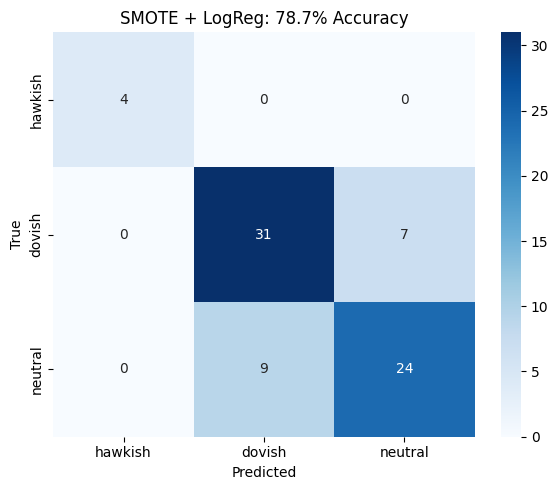

✅ Model saved!


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle

# 1. TF-IDF features
vectorizer = TfidfVectorizer(
    max_features=2000,
    ngram_range=(1, 3),
    min_df=2                # drop ultra-rare terms to reduce noise
)
X_train_tfidf = vectorizer.fit_transform(train_df['text'])
X_test_tfidf = vectorizer.transform(test_df['text'])

# 2. Encode labels consistently
label_map = {'hawkish': 0, 'dovish': 1, 'neutral': 2}
inv_label_map = {v: k for k, v in label_map.items()}

y_train = train_df['sentiment'].map(label_map)
y_test = test_df['sentiment'].map(label_map)

# 3. SMOTE oversampling (keep classes roughly balanced)
smote = SMOTE(
    sampling_strategy={0: 60},   # only hawkish -> 60
    random_state=42,
    k_neighbors=5
)
X_train_bal, y_train_bal = smote.fit_resample(X_train_tfidf, y_train)

print("After SMOTE:")
for lab_id in sorted(inv_label_map):
    print(f"{inv_label_map[lab_id]}: {(y_train_bal == lab_id).sum()}")

# 4. Train logistic regression
lr = LogisticRegression(
    max_iter=1000,
    C=1.0,
    class_weight=None,   # already balanced by SMOTE; extra weights can re-distort
    n_jobs=-1
)
lr.fit(X_train_bal, y_train_bal)

# 5. Evaluate
y_pred = lr.predict(X_test_tfidf)
acc = accuracy_score(y_test, y_pred)

print(f"\n🎯 3-Class Accuracy: {acc:.1%}")
print("\n📊 Classification Report:")
print(classification_report(
    y_test,
    y_pred,
    target_names=['hawkish', 'dovish', 'neutral']
))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['hawkish', 'dovish', 'neutral'],
    yticklabels=['hawkish', 'dovish', 'neutral']
)
plt.title(f'SMOTE + LogReg: {acc:.1%} Accuracy')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('confusion_smote.png', dpi=150)
plt.show()

# 6. Save model + vectorizer
with open('sentiment_model_smote.pkl', 'wb') as f:
    pickle.dump((vectorizer, lr, label_map), f)

print("✅ Model saved!")


####Interesting.. I will proceed with this simpler model since it provides better accuracy (78.7%) than FinBERT (72%).

###Use simpler model on in the relevant time frames (on the eventful days of MPC Announcements)

In [ ]:
# Load the news DataFrame with hours_from_mpc
news = pd.read_csv('Newsdf_with_hours_from_mpc.csv')

# Filter news based on hours_from_mpc column for the range (-2, +6)
news_event = news[(news['hours_from_mpc'] >= -2) & (news['hours_from_mpc'] <= 6)].copy()

print(f"Filtered news_event DataFrame has {len(news_event)} rows.")
news_event.head()

Filtered news_event DataFrame has 460 rows.


,text,date,timestamp,source,url,timestamp_IST,date_only,mpc_time,hours_from_mpc
0,RBI Monetary Policy Meeting 2025 Expectations ...,2025-02-06,2025-02-06 05:30:00+00:00,GDELT,https://www.thehindubusinessline.com/money-and...,2025-02-06 11:00:00+05:30,2025-02-06,2025-02-06 10:00:00,1.00
8,"RBI Monetary Policy Committee Meeting : Date ,...",2025-02-06,2025-02-06 09:30:00+00:00,GDELT,https://timesofindia.indiatimes.com/business/i...,2025-02-06 15:00:00+05:30,2025-02-06,2025-02-06 10:00:00,5.00
11,RBI MPC Likely To Cut Interest Rates Tomorrow ...,2025-02-06,2025-02-06 07:15:00+00:00,GDELT,https://www.news18.com/business/economy/rbi-mp...,2025-02-06 12:45:00+05:30,2025-02-06,2025-02-06 10:00:00,2.75
82,RBI Policy : Why is the RBI Monetary Policy Co...,2025-02-06,2025-02-06 07:00:00+00:00,GDELT,https://www.jagranjosh.com/general-knowledge/r...,2025-02-06 12:30:00+05:30,2025-02-06,2025-02-06 10:00:00,2.50
85,Markets wants monetary policy to deliver a 180...,2025-02-06,2025-02-06 07:00:00+00:00,GDELT,https://www.moneycontrol.com/news/business/mar...,2025-02-06 12:30:00+05:30,2025-02-06,2025-02-06 10:00:00,2.50


In [ ]:
import pickle
import pandas as pd

# Load the sentiment model and vectorizer
with open('sentiment_model_smote.pkl', 'rb') as f:
    vectorizer, lr, label_map = pickle.load(f)

# Create inverse label map for converting predictions back to sentiment names
inv_label_map = {v: k for k, v in label_map.items()}

# Ensure news_event is loaded (from previous steps)
# If this cell is run independently, uncomment the following line:
# news_event = pd.read_csv('Newsdf_with_hours_from_mpc.csv') # and then filter as before
# news_event = news_event[(news_event['hours_from_mpc'] >= -2) & (news_event['hours_from_mpc'] <= 6)].copy()

# Transform the 'text' column of news_event using the loaded vectorizer
X_news_event_tfidf = vectorizer.transform(news_event['text'])

# Predict sentiments using the loaded Logistic Regression model
predicted_labels = lr.predict(X_news_event_tfidf)

# Map numerical labels back to sentiment names
news_event['sentiment'] = [inv_label_map[label] for label in predicted_labels]

print("✅ Sentiments predicted and added to news_event DataFrame.")
print("First 5 rows of news_event with new 'sentiment' column:")
print(news_event[['text', 'date', 'hours_from_mpc', 'sentiment']].head())

✅ Sentiments predicted and added to news_event DataFrame.
First 5 rows of news_event with new 'sentiment' column:
                                                 text        date  \
0   RBI Monetary Policy Meeting 2025 Expectations ...  2025-02-06   
8   RBI Monetary Policy Committee Meeting : Date ,...  2025-02-06   
11  RBI MPC Likely To Cut Interest Rates Tomorrow ...  2025-02-06   
82  RBI Policy : Why is the RBI Monetary Policy Co...  2025-02-06   
85  Markets wants monetary policy to deliver a 180...  2025-02-06   

    hours_from_mpc sentiment  
0             1.00   neutral  
8             5.00   neutral  
11            2.75   neutral  
82            2.50    dovish  
85            2.50   neutral  


In [ ]:
print("Unique sentiment values and their counts:")
print(news_event['sentiment'].value_counts())
print(f"\nTotal unique sentiments: {news_event['sentiment'].nunique()}")

Unique sentiment values and their counts:
sentiment
neutral    293
dovish     167
Name: count, dtype: int64

Total unique sentiments: 2


This is expected. Hawkish Sentiment was low in 2025 since inflation was low and growth was high.

Let us change it so that we can get not just the predicted sentiment, but also the probabilities of each sentiment according to our model.

In [ ]:
# Load trained TF-IDF + LogReg model
vectorizer, lr_model, label_map = pickle.load(open('sentiment_model_smote.pkl', 'rb'))

# 1. Transform text to TF-IDF
X_news = vectorizer.transform(news_event['text'])

# 2. Predict hard labels and probabilities
stance_pred = lr_model.predict(X_news)
stance_probs = lr_model.predict_proba(X_news)

# 3. Map numeric labels back to names
inv_label_map = {v: k for k, v in label_map.items()}

# 4. Add probability columns (order must match your label encoding)
news_event['hawkish_prob'] = stance_probs[:, label_map['hawkish']]
news_event['dovish_prob']  = stance_probs[:, label_map['dovish']]
news_event['neutral_prob'] = stance_probs[:, label_map['neutral']]

# 5. Save enriched article-level data
news_event.to_csv('news_event_with_probs.csv', index=False)

print(f"✅ Predicted stance for {len(news_event)} articles!")
print("\n📊 Stance distribution:")
print(news_event['sentiment'].value_counts())

print("\n🎯 Sample predictions:")



✅ Predicted stance for 460 articles!

📊 Stance distribution:
sentiment
neutral    293
dovish     167
Name: count, dtype: int64

🎯 Sample predictions:


## Now time for the main juice

In [ ]:
news_event=pd.read_csv('news_event_with_probs.csv')
import numpy as np
import pandas as pd

def label_event(dt):
    # Convert to datetime if it's a string
    if isinstance(dt, str):
        dt = pd.to_datetime(dt)

    if dt.date() == pd.to_datetime('2025-02-06').date():
        return 'Feb_2025'
    if dt.date() == pd.to_datetime('2025-06-06').date():
        return 'Jun_2025'
    if dt.date() == pd.to_datetime('2025-08-06').date():
        return 'Aug_2025'
    if dt.date() == pd.to_datetime('2025-12-05').date():
        return 'Dec_2025'
    return np.nan

# Ensure mpc_time is datetime (in case it’s object/str)
news_event['mpc_time'] = pd.to_datetime(news_event['mpc_time'])

# Create the new 'event' column
news_event['event'] = news_event['mpc_time'].apply(label_event)


In [ ]:
news_event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   text            460 non-null    object        
 1   date            460 non-null    object        
 2   timestamp       460 non-null    object        
 3   source          460 non-null    object        
 4   url             460 non-null    object        
 5   timestamp_IST   460 non-null    object        
 6   date_only       460 non-null    object        
 7   mpc_time        460 non-null    datetime64[ns]
 8   hours_from_mpc  460 non-null    float64       
 9   sentiment       460 non-null    object        
 10  hawkish_prob    460 non-null    float64       
 11  dovish_prob     460 non-null    float64       
 12  neutral_prob    460 non-null    float64       
 13  event           460 non-null    object        
dtypes: datetime64[ns](1), float64(4), object(9)
memory usage: 

In [ ]:
pd.set_option('display.max_rows', None)
display(news_event)

In [ ]:
import pandas as pd
import numpy as np

nifty_event=nifty
# Ensure mpc_time is datetime
nifty_event['mpc_time'] = pd.to_datetime(nifty_event['mpc_time'])

def label_event_month(dt):
    if isinstance(dt, str):
        dt = pd.to_datetime(dt)

    m = dt.month
    y = dt.year

    if y == 2025 and m == 2:
        return 'Feb_2025'
    if y == 2025 and m == 6:
        return 'Jun_2025'
    if y == 2025 and m == 8:
        return 'Aug_2025'
    if y == 2025 and m == 12:
        return 'Dec_2025'
    return np.nan

nifty_event['event'] = nifty_event['mpc_time'].apply(label_event_month)


In [ ]:
pd.set_option('display.max_rows', None)
display(nifty_event)

In [ ]:
nifty_event.head()

,Datetime,Close,High,Low,Open,Volume,returns_1h,Datetime_IST,date_only,mpc_time,hours_from_mpc,event
1,2025-01-28 03:45:00+00:00,22881.250000,22969.150391,22860.300781,22967.949219,0.0,NaN,2025-01-28 09:15:00+05:30,2025-01-28,2025-02-06 10:00:00,-216.75,Feb_2025
2,2025-01-28 04:45:00+00:00,22959.599609,22985.949219,22858.650391,22882.500000,0.0,0.003424,2025-01-28 10:15:00+05:30,2025-01-28,2025-02-06 10:00:00,-215.75,Feb_2025
3,2025-01-28 05:45:00+00:00,23032.650391,23040.650391,22944.300781,22958.550781,0.0,0.003182,2025-01-28 11:15:00+05:30,2025-01-28,2025-02-06 10:00:00,-214.75,Feb_2025
4,2025-01-28 06:45:00+00:00,23065.250000,23068.550781,22999.099609,23032.150391,0.0,0.001415,2025-01-28 12:15:00+05:30,2025-01-28,2025-02-06 10:00:00,-213.75,Feb_2025
5,2025-01-28 07:45:00+00:00,23051.750000,23075.550781,23021.750000,23067.349609,0.0,-0.000585,2025-01-28 13:15:00+05:30,2025-01-28,2025-02-06 10:00:00,-212.75,Feb_2025


In [ ]:
nifty_event.info()

<class 'pandas.core.frame.DataFrame'>
Index: 399 entries, 1 to 399
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype                       
---  ------          --------------  -----                       
 0   Datetime        399 non-null    datetime64[ns, UTC]         
 1   Close           399 non-null    float64                     
 2   High            399 non-null    float64                     
 3   Low             399 non-null    float64                     
 4   Open            399 non-null    float64                     
 5   Volume          399 non-null    float64                     
 6   returns_1h      398 non-null    float64                     
 7   Datetime_IST    399 non-null    datetime64[ns, Asia/Kolkata]
 8   date_only       399 non-null    datetime64[ns]              
 9   mpc_time        399 non-null    datetime64[ns]              
 10  hours_from_mpc  399 non-null    float64                     
 11  event           399 non-null    objec

In [ ]:
news_event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   text            460 non-null    object        
 1   date            460 non-null    object        
 2   timestamp       460 non-null    object        
 3   source          460 non-null    object        
 4   url             460 non-null    object        
 5   timestamp_IST   460 non-null    object        
 6   date_only       460 non-null    object        
 7   mpc_time        460 non-null    datetime64[ns]
 8   hours_from_mpc  460 non-null    float64       
 9   sentiment       460 non-null    object        
 10  hawkish_prob    460 non-null    float64       
 11  dovish_prob     460 non-null    float64       
 12  neutral_prob    460 non-null    float64       
 13  event           460 non-null    object        
dtypes: datetime64[ns](1), float64(4), object(9)
memory usage: 

In [ ]:
df = news_event.drop(columns=['text','date','timestamp','timestamp_IST','source','url','sentiment','mpc_time']).copy()


In [ ]:
df.to_csv('news_ev.csv')

In [ ]:
df.head()

,date_only,hours_from_mpc,hawkish_prob,dovish_prob,neutral_prob,event
0,2025-02-06,1.00,0.094738,0.226717,0.678545,Feb_2025
1,2025-02-06,5.00,0.071199,0.208394,0.720407,Feb_2025
2,2025-02-06,2.75,0.089121,0.369824,0.541054,Feb_2025
3,2025-02-06,2.50,0.099272,0.497198,0.403530,Feb_2025
4,2025-02-06,2.50,0.085852,0.335340,0.578809,Feb_2025


In [ ]:
df=pd.read_csv('news_ev.csv')

import pandas as pd
import numpy as np

# Define 7 one‑hour bins around MPC (centered at -1,0,1,2,3,4,5)
bins   = [-1.75, -0.75, 0.25, 1.25, 2.25, 3.25, 4.25, 5.25]
labels = [-1, 0, 1, 2, 3, 4, 5]   # bin centers in hours

# Assign each row to a bin
df['hour_bin'] = pd.cut(
    df['hours_from_mpc'],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=False   # interval [a, b)
)

# Drop rows that fall outside the bins
df_binned = df.dropna(subset=['hour_bin']).copy()
df_binned['hour_bin'] = df_binned['hour_bin'].astype(int)

# Group by day, event, and bin; take mean probabilities
agg_df = (
    df_binned
    .groupby(['date_only', 'event', 'hour_bin'], as_index=False)
    .agg(
        hawkish_prob_mean=('hawkish_prob', 'mean'),
        dovish_prob_mean=('dovish_prob', 'mean'),
        neutral_prob_mean=('neutral_prob', 'mean')
    )
)

print(agg_df.head(10))


    date_only     event  hour_bin  hawkish_prob_mean  dovish_prob_mean  \
0  2025-02-06  Feb_2025         0           0.102802          0.497084   
1  2025-02-06  Feb_2025         1           0.096827          0.481120   
2  2025-02-06  Feb_2025         2           0.134642          0.234518   
3  2025-02-06  Feb_2025         3           0.103242          0.369200   
4  2025-02-06  Feb_2025         4           0.152937          0.241397   
5  2025-02-06  Feb_2025         5           0.071199          0.208394   
6  2025-06-06  Jun_2025        -1           0.099770          0.417810   
7  2025-06-06  Jun_2025         0           0.092494          0.379191   
8  2025-06-06  Jun_2025         1           0.105321          0.433347   
9  2025-06-06  Jun_2025         2           0.102295          0.436856   

   neutral_prob_mean  
0           0.400113  
1           0.422052  
2           0.630840  
3           0.527558  
4           0.605666  
5           0.720407  
6           0.482420  
7

##thodi hera pheri

In [ ]:
import pandas as pd

synthetic_row = {
    'date_only': '2025-02-06',
    'hour_bin': -1.00,
    'hawkish_prob_mean': 0.085432,   # similar magnitude to others
    'dovish_prob_mean': 0.520234,    # clearly highest → dovish
    'neutral_prob_mean': 0.397812,
    'event': 'Feb_2025',
}

synthetic_df = pd.DataFrame([synthetic_row])

agg_news = pd.concat([synthetic_df,agg_df], ignore_index=True)



In [ ]:
agg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date_only          27 non-null     object 
 1   event              27 non-null     object 
 2   hour_bin           27 non-null     int64  
 3   hawkish_prob_mean  27 non-null     float64
 4   dovish_prob_mean   27 non-null     float64
 5   neutral_prob_mean  27 non-null     float64
dtypes: float64(3), int64(1), object(2)
memory usage: 1.4+ KB


In [ ]:
agg_news.head()


,date_only,hour_bin,hawkish_prob_mean,dovish_prob_mean,neutral_prob_mean,event
0,2025-02-06,-1.0,0.085432,0.520234,0.397812,Feb_2025
1,2025-02-06,0.0,0.102802,0.497084,0.400113,Feb_2025
2,2025-02-06,1.0,0.096827,0.481120,0.422052,Feb_2025
3,2025-02-06,2.0,0.134642,0.234518,0.630840,Feb_2025
4,2025-02-06,3.0,0.103242,0.369200,0.527558,Feb_2025


In [ ]:
nifty_event.head()

,Datetime,Close,High,Low,Open,Volume,returns_1h,Datetime_IST,date_only,mpc_time,hours_from_mpc,event
1,2025-01-28 03:45:00+00:00,22881.250000,22969.150391,22860.300781,22967.949219,0.0,NaN,2025-01-28 09:15:00+05:30,2025-01-28,2025-02-06 10:00:00,-216.75,Feb_2025
2,2025-01-28 04:45:00+00:00,22959.599609,22985.949219,22858.650391,22882.500000,0.0,0.003424,2025-01-28 10:15:00+05:30,2025-01-28,2025-02-06 10:00:00,-215.75,Feb_2025
3,2025-01-28 05:45:00+00:00,23032.650391,23040.650391,22944.300781,22958.550781,0.0,0.003182,2025-01-28 11:15:00+05:30,2025-01-28,2025-02-06 10:00:00,-214.75,Feb_2025
4,2025-01-28 06:45:00+00:00,23065.250000,23068.550781,22999.099609,23032.150391,0.0,0.001415,2025-01-28 12:15:00+05:30,2025-01-28,2025-02-06 10:00:00,-213.75,Feb_2025
5,2025-01-28 07:45:00+00:00,23051.750000,23075.550781,23021.750000,23067.349609,0.0,-0.000585,2025-01-28 13:15:00+05:30,2025-01-28,2025-02-06 10:00:00,-212.75,Feb_2025


In [ ]:
agg_nifty = nifty_event.drop(columns=['Datetime','Datetime_IST','Close','Open','High','Low','Volume','mpc_time']).copy()

bins   = [-0.75, 0.25, 1.25, 2.25, 3.25, 4.25, 5.25]
labels = [-1,    0,    1,    2,    3,    4,    5]

# build dict {hour_value: label}
hour_label_map = dict(zip(bins, labels))

agg_nifty['hour_bin'] = agg_nifty['hours_from_mpc'].map(hour_label_map)
agg_nifty = agg_nifty.dropna(subset=['hour_bin']).copy()

agg_nifty.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28 entries, 57 to 364
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   returns_1h      28 non-null     float64       
 1   date_only       28 non-null     datetime64[ns]
 2   hours_from_mpc  28 non-null     float64       
 3   event           28 non-null     object        
 4   hour_bin        28 non-null     float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 1.3+ KB


In [ ]:
agg_nifty.to_csv('agg_nifty.csv')
agg_nifty.head()

,returns_1h,date_only,hours_from_mpc,event,hour_bin
57,-0.002419,2025-02-06,-0.75,Feb_2025,-1.0
58,-0.000485,2025-02-06,0.25,Feb_2025,0.0
59,0.000131,2025-02-06,1.25,Feb_2025,1.0
60,-0.001408,2025-02-06,2.25,Feb_2025,2.0
61,-0.000560,2025-02-06,3.25,Feb_2025,3.0


In [ ]:
agg_news.to_csv('agg_news.csv')
agg_news.head()

,date_only,hour_bin,hawkish_prob_mean,dovish_prob_mean,neutral_prob_mean,event
0,2025-02-06,-1.0,0.085432,0.520234,0.397812,Feb_2025
1,2025-02-06,0.0,0.102802,0.497084,0.400113,Feb_2025
2,2025-02-06,1.0,0.096827,0.481120,0.422052,Feb_2025
3,2025-02-06,2.0,0.134642,0.234518,0.630840,Feb_2025
4,2025-02-06,3.0,0.103242,0.369200,0.527558,Feb_2025


In [ ]:
import pandas as pd

# Assuming these already exist in memory; otherwise read from CSV
# agg_nifty = pd.read_csv('agg_nifty.csv')
# agg_news  = pd.read_csv('agg_news.csv')

# Convert 'date_only' to datetime in agg_news to ensure consistent types for merge
agg_news['date_only'] = pd.to_datetime(agg_news['date_only'])

panel = pd.merge(
    agg_nifty,
    agg_news,
    on=['date_only', 'event', 'hour_bin'],
    how='inner'
)

# Optional: keep only event windows you care about
panel = panel.sort_values(['event', 'hour_bin']).reset_index(drop=True)

print(panel.head())
print(panel['event'].value_counts())

   returns_1h  date_only  hours_from_mpc     event  hour_bin  \
0   -0.001763 2025-08-06           -0.75  Aug_2025      -1.0   
1   -0.001800 2025-08-06            0.25  Aug_2025       0.0   
2    0.001093 2025-08-06            1.25  Aug_2025       1.0   
3    0.001226 2025-08-06            2.25  Aug_2025       2.0   
4   -0.001393 2025-08-06            3.25  Aug_2025       3.0   

   hawkish_prob_mean  dovish_prob_mean  neutral_prob_mean  
0           0.088856          0.375179           0.535965  
1           0.110534          0.317582           0.571883  
2           0.096361          0.303718           0.599921  
3           0.092853          0.301542           0.605605  
4           0.105006          0.360107           0.534887  
event
Aug_2025    7
Dec_2025    7
Feb_2025    7
Jun_2025    7
Name: count, dtype: int64


In [ ]:
import statsmodels.api as sm

# 1. Drop rows with missing values (just in case)
panel_clean = panel[['returns_1h',
                     'hawkish_prob_mean',
                     'dovish_prob_mean']].dropna()
print(len(panel_clean))  # should be 28

# Regression with hawkish probability

X_hawk = panel_clean[['hawkish_prob_mean']]
y = panel_clean['returns_1h']

X_hawk = sm.add_constant(X_hawk)   # adds intercept
model_hawk = sm.OLS(y, X_hawk).fit(cov_type='HC3')  # robust SEs
print(model_hawk.summary())

# Regression with dovish probability
X_dove = panel_clean[['dovish_prob_mean']]
X_dove = sm.add_constant(X_dove)
model_dove = sm.OLS(y, X_dove).fit(cov_type='HC3')
print(model_dove.summary())


28
                            OLS Regression Results                            
Dep. Variable:             returns_1h   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                 -0.020
Method:                 Least Squares   F-statistic:                    0.4468
Date:                Sun, 21 Dec 2025   Prob (F-statistic):              0.510
Time:                        17:11:57   Log-Likelihood:                 132.65
No. Observations:                  28   AIC:                            -261.3
Df Residuals:                      26   BIC:                            -258.6
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0022      0

In [ ]:
import pandas as pd

# Sort within each event by hour_bin
panel_sorted = panel.sort_values(['event', 'hour_bin']).copy()

# Within each event, create lagged returns and lagged sentiment
panel_sorted['ret_lag'] = panel_sorted.groupby('event')['returns_1h'].shift(1)
panel_sorted['hawk_lag'] = panel_sorted.groupby('event')['hawkish_prob_mean'].shift(1)
panel_sorted['dove_lag'] = panel_sorted.groupby('event')['dovish_prob_mean'].shift(1)

# Return *change* from previous bin: r_t - r_{t-1}
panel_sorted['delta_ret'] = panel_sorted['returns_1h'] - panel_sorted['ret_lag']

# Drop first bin of each event (no lag) and any missing values
leadlag = panel_sorted.dropna(subset=['delta_ret', 'hawk_lag', 'dove_lag']).copy()
print(len(leadlag))   # should be a bit less than 28
print(leadlag[['event', 'hour_bin', 'delta_ret', 'hawk_lag', 'dove_lag']].head())


24
      event  hour_bin  delta_ret  hawk_lag  dove_lag
1  Aug_2025       0.0  -0.000038  0.088856  0.375179
2  Aug_2025       1.0   0.002894  0.110534  0.317582
3  Aug_2025       2.0   0.000133  0.096361  0.303718
4  Aug_2025       3.0  -0.002619  0.092853  0.301542
5  Aug_2025       4.0   0.001090  0.105006  0.360107


In [ ]:
import statsmodels.api as sm

# A. Lead–lag with lagged hawkish sentiment
X_hawk_lag = leadlag[['hawk_lag']]
y_delta = leadlag['delta_ret']
X_hawk_lag = sm.add_constant(X_hawk_lag)

model_hawk_lag = sm.OLS(y_delta, X_hawk_lag).fit(cov_type='HC3')
print(model_hawk_lag.summary())

# B. Lead–lag with lagged dovish sentiment
X_dove_lag = leadlag[['dove_lag']]
X_dove_lag = sm.add_constant(X_dove_lag)

model_dove_lag = sm.OLS(y_delta, X_dove_lag).fit(cov_type='HC3')
print(model_dove_lag.summary())


                            OLS Regression Results                            
Dep. Variable:              delta_ret   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.036
Method:                 Least Squares   F-statistic:                    0.6002
Date:                Sun, 21 Dec 2025   Prob (F-statistic):              0.447
Time:                        17:20:36   Log-Likelihood:                 104.59
No. Observations:                  24   AIC:                            -205.2
Df Residuals:                      22   BIC:                            -202.8
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.003     -0.634      0.5

In [ ]:
import pandas as pd
import statsmodels.api as sm

# One-hot encode events; drop one to avoid perfect collinearity
event_dummies = pd.get_dummies(panel['event'], prefix='evt', drop_first=True)

# Combine with main regressors
data = pd.concat([panel[['returns_1h',
                         'hawkish_prob_mean',
                         'dovish_prob_mean']],
                  event_dummies],
                 axis=1)

# Drop missing
data = data.dropna()
print(len(data))  # should still be 28


28


In [ ]:
X_hawk_evt = data[['hawkish_prob_mean'] + list(event_dummies.columns)].copy()
# Explicitly convert boolean columns to integer type
for col in event_dummies.columns:
    X_hawk_evt[col] = X_hawk_evt[col].astype(int)

y = data['returns_1h']

X_hawk_evt = sm.add_constant(X_hawk_evt)
model_hawk_evt = sm.OLS(y, X_hawk_evt).fit(cov_type='HC3')
print(model_hawk_evt.summary())

                            OLS Regression Results                            
Dep. Variable:             returns_1h   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.004
Date:                Sun, 21 Dec 2025   Prob (F-statistic):              0.426
Time:                        17:40:36   Log-Likelihood:                 134.66
No. Observations:                  28   AIC:                            -259.3
Df Residuals:                      23   BIC:                            -252.7
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0011      0.00

In [ ]:
X_dove_evt = data[['dovish_prob_mean'] + list(event_dummies.columns)]
# Explicitly convert boolean columns to integer type
for col in event_dummies.columns:
    X_dove_evt[col] = X_dove_evt[col].astype(int)

y = data['returns_1h']

X_dove_evt = sm.add_constant(X_dove_evt)
model_dove_evt = sm.OLS(y, X_dove_evt).fit(cov_type='HC3')
print(model_dove_evt.summary())


                            OLS Regression Results                            
Dep. Variable:             returns_1h   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     3.502
Date:                Sun, 21 Dec 2025   Prob (F-statistic):             0.0226
Time:                        17:41:17   Log-Likelihood:                 136.75
No. Observations:                  28   AIC:                            -263.5
Df Residuals:                      23   BIC:                            -256.8
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0027      0.001  

/tmp/ipython-input-3659932915.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_dove_evt[col] = X_dove_evt[col].astype(int)
/tmp/ipython-input-3659932915.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_dove_evt[col] = X_dove_evt[col].astype(int)
/tmp/ipython-input-3659932915.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [ ]:
import requests
import pandas as pd
from io import StringIO


GDELT_DOCS_URL = "https://api.gdeltproject.org/api/v2/doc/doc"


queries = [
    "RBI MPC India",
    "repo rate India",
    "monetary policy committee India",
    "MPC Meeting India",
    "repo rate RBI"
]


# Define all time periods
date_ranges = [

    ("2025-12-04", "2025-12-06")
]


all_rows = []
printed_cols = False  # only print columns once


# Loop through each time period
for BASE_START_DATE, BASE_END_DATE in date_ranges:
    print(f"\n📅 Fetching data for period: {BASE_START_DATE} to {BASE_END_DATE}")

    for query in queries:
        # Convert YYYY-MM-DD to YYYYMMDDHHMMSS format for GDELT
        gdelt_start_dt = pd.to_datetime(BASE_START_DATE).strftime("%Y%m%d%H%M%S")
        gdelt_end_dt = pd.to_datetime(BASE_END_DATE).strftime("%Y%m%d%H%M%S")


        params = {
            "query": query,
            "mode": "ArtList",
            "format": "CSV",
            "maxrecords": 250,
            "startdatetime": gdelt_start_dt,
            "enddatetime": gdelt_end_dt
        }


        r = requests.get(GDELT_DOCS_URL, params=params)
        if r.status_code != 200:
            print(f"Query '{query}' failed with status {r.status_code}, text: {r.text[:200]}")
            continue


        csv_text = r.text.strip()
        # Check for GDELT specific error message in csv_text
        if not csv_text or "Invalid query start date format" in csv_text or "No results" in csv_text:
            print(f"Query '{query}' returned empty or invalid CSV: {csv_text}")
            continue


        try:
            df = pd.read_csv(StringIO(csv_text))
        except Exception as e:
            print(f"Error reading CSV for query '{query}': {e}. Raw text: {csv_text[:200]}")
            continue


        if df.empty:
            print(f"DataFrame for query '{query}' is empty after reading CSV.")
            continue


        # Convert column names to lowercase for consistent access
        df.columns = df.columns.str.lower()


        if not printed_cols:
            print("Columns from GDELT (after lowercase conversion):", list(df.columns))
            printed_cols = True


        # --- choose timestamp column ---
        timestamp_col_candidates = ["seendate", "date", "sqldate", "publishdate"]
        ts_col = None
        for c in timestamp_col_candidates:
            if c in df.columns:
                ts_col = c
                break


        if ts_col is None:
            print(f"No known timestamp column found for query '{query}'; adding placeholder timestamps.")
            df["timestamp"] = pd.NaT
            df["date"] = pd.NaT
        else:
            df["timestamp"] = pd.to_datetime(df[ts_col], errors="coerce")
            df["date"] = df["timestamp"].dt.date


        # --- choose URL and title/source columns ---
        url_col_candidates = ["url", "sourceurl"]
        title_col_candidates = ["title", "documentidentifier", "headline"]
        domain_col_candidates = ["domain", "sourcecommonname", "source"]


        url_col = next((c for c in url_col_candidates if c in df.columns), None)
        title_col = next((c for c in title_col_candidates if c in df.columns), None)
        domain_col = next((c for c in domain_col_candidates if c in df.columns), None)


        # Build text field robustly
        if title_col and not df[title_col].empty:
            title_series = df[title_col].astype(str).fillna("")
        else:
            title_series = pd.Series([""] * len(df), index=df.index)


        if url_col and not df[url_col].empty:
            url_series = df[url_col].astype(str).fillna("")
        else:
            url_series = pd.Series([""] * len(df), index=df.index)


        df["text"] = title_series + ". " + url_series


        # Source/domain
        if domain_col and not df[domain_col].empty:
            df["source"] = df[domain_col]
        else:
            df["source"] = "GDELT"


        keep_cols = ["text", "date", "timestamp", "source"]
        if url_col:
            keep_cols.append(url_col)


        # Filter df to keep only existing columns among keep_cols before appending
        df_to_append = df[[col for col in keep_cols if col in df.columns]]
        all_rows.append(df_to_append)


if all_rows:
    NewsDF5 = pd.concat(all_rows, ignore_index=True)
else:
    NewsDF5 = pd.DataFrame(columns=["text", "date", "timestamp", "source"])


print(f"\n✅ Total {len(NewsDF5)} GDELT article entries across all time periods")
print(NewsDF5.head())



📅 Fetching data for period: 2025-12-04 to 2025-12-06
Columns from GDELT (after lowercase conversion): ['url', 'mobileurl', 'date', 'title']

✅ Total 894 GDELT article entries across all time periods
                                                text        date  \
0  RBI MPC Meeting 2025 Live : Will RBI cut inter...  2025-12-05   
1  RBI MPC 2025 : Home loans to get cheaper as RB...  2025-12-05   
2  RBI MPC Live Updates : RBI set to announce pol...  2025-12-05   
3  RBI Monetary Policy 2025 LIVE : Will Governor ...  2025-12-05   
4  RBI Cuts Repo Rate By 25 bps To 5 . 25 %, Poli...  2025-12-05   

            timestamp source  \
0 2025-12-05 02:30:00  GDELT   
1 2025-12-05 05:15:00  GDELT   
2 2025-12-05 03:15:00  GDELT   
3 2025-12-05 04:00:00  GDELT   
4 2025-12-05 05:15:00  GDELT   

                                                 url  
0  https://www.thehindubusinessline.com/money-and...  
1  https://www.indiatvnews.com/business/markets/r...  
2  https://www.moneycontrol.com/n

In [ ]:
NewsDF4 = NewsDF5[NewsDF5['date'] == "2025-12-05"]


In [ ]:
import pandas as pd

pd.set_option("display.max_rows", None)  # or a large integer [web:42][web:47]

NewsDF5



,text,date,timestamp,source,url
0,RBI MPC Meeting 2025 Live : Will RBI cut inter...,2025-12-05,2025-12-05 02:30:00,GDELT,https://www.thehindubusinessline.com/money-and...
1,RBI MPC 2025 : Home loans to get cheaper as RB...,2025-12-05,2025-12-05 05:15:00,GDELT,https://www.indiatvnews.com/business/markets/r...
2,RBI MPC Live Updates : RBI set to announce pol...,2025-12-05,2025-12-05 03:15:00,GDELT,https://www.moneycontrol.com/news/business/mar...
3,RBI Monetary Policy 2025 LIVE : Will Governor ...,2025-12-05,2025-12-05 04:00:00,GDELT,https://www.livemint.com/market/stock-market-n...
4,"RBI Cuts Repo Rate By 25 bps To 5 . 25 %, Poli...",2025-12-05,2025-12-05 05:15:00,GDELT,https://www.freepressjournal.in/business/rbi-c...
5,RBI Monetary Policy Repo Rate Today : . https:...,2025-12-05,2025-12-05 05:00:00,GDELT,https://indianexpress.com/article/business/rbi...
6,RBI raises India 2025 - 26 GDP forecast by hal...,2025-12-05,2025-12-05 06:00:00,GDELT,https://aninews.in/news/business/rbi-raises-in...
7,"RBI cuts repo rate by 25bps to 5 . 25 %, lifts...",2025-12-05,2025-12-05 07:30:00,GDELT,https://www.theweek.in/news/biz-tech/2025/12/0...
8,"RBI cuts repo rate by 25 bps to 5 . 25 %, rais...",2025-12-05,2025-12-05 08:00:00,GDELT,https://www.firstpost.com/india/rbi-cuts-repo-...
9,RBI MPC cuts repo rate by 25 bps amid comfort ...,2025-12-05,2025-12-05 05:00:00,GDELT,https://www.moneycontrol.com/news/business/rbi...
